# Introduction

Class imbalance in classification problems is a long-standing complication. All data scientists hear about it; many know some off-the-shelf techniques to deal with it; yet it is still a complicated problem, because there are not real one-size-fits-all approaches to tackling imbalanced classification problems.

We aim to share a bit of our experience and practices on how to attack this issue. This is a constantly-evolving compilation of techniques that we have employed over the years to address complications that appeared in our daily work as data scientists, especially dealing with the problem of creditworthiness assessment.

## Yet another book on imbalanced learning?

There are many articles on class imbalance in standard data science forums. Similarly, there are both academic books [1, 2] and more applied materials [3, 4]. Indeed, there is a plethora of available resources for the practitioner to refer to.

Our experience with imbalanced classification is that it is this variety that makes the subject more difficult: there are so many techniques and recommendations that one often gets confused on which to apply. All? None?

Our purpose with this document is to share our best practices on binary classification under class imbalance, from a practical point of view. We try to answer the question:

> What should I be worrying about if I have class imbalance?


## Who is this book for?

Everyone. The language and formalism might be more suited for data scientists, but we hope the techniques presented here can help anyone working with data.

## “Imbalance” might mean something different from what you think

In most of the literature, class imbalance refers to situations where the proportion between the two classes is far from 50%, or equivalently, when the proportion of the so-called positive class against the rest of the dataset is small. There is no consensus on what “far” or “small” mean in the previous sentence: anecdotal experience for the smallness varies across 4 orders of magnitude, from 10% to 0.01%. 

As pointed out by [1], however, more than the *relative* imbalance between classes, it is perhaps more important – and less common – to look at the *absolute* imbalance, i.e. by how much the total amount of positive samples is smaller than those of the negative class. A dataset A with 10,000 samples of the positive class, out of one million total samples, has a 1% imbalance, yet the difficulty of the problem is evidently different from that of a dataset B, with 1,000 total samples, where 10 are in the positive class.

Relative and absolute imbalance do not imply one another, but they are certainly related. If a large dataset (with length $10^6$, say) has an extreme imbalance ratio (say $10^{-4}$), it is likely that the absolute value of samples in the positive class will be small (in this case, $10^6 \times 10^{-4} = 100$, which is considered small by most practitioners). Similarly, in industries such as health or pharmacy, in which clinical trials are expensive and not numerous, both the total sample size and the incidence of the positive class are small.

In other words, imbalanced classification deals with two different, but correlated, issues:

1. **Relative data imbalance**, which affects proportion-based metrics such as training losses and model calibration;

2. **Small data samples**, which affects everything from model performance, estimation of feature importance, to interpretability and feature selection methods.

In practice, we try to focus on methods to deal with the former issue; however, we will commonly see that when reaching a certain level of imbalance, we fall into the latter.

## Notation

Throughout this book, we will consider the standard binary classification problem as follows. Let $(X,Y)$ be jointly distributed random variables, where $Y$ takes values on $\{0,1\}$.

> Other references choose to use $\{-1,1\}$, especially in cases such as support vector machines where this cleans up the notation.

We do not care much about the set where $X$ takes values; for all purposes, it might be considered as some subset of $\mathbb R^n$. 

Random variables are denoted in uppercase, whereas the values they take are written in lowercase. So, for instance, we might write $\mathbb P(Y=y)$.

Following these notations, we observe $N$ iid copies of $(X,Y)$, namely, $\{(X_i, Y_i)\}_{i=1}^N$ taking values $\{x_i, y_i\}_{i=1}^N$, where $y_i \in \{0,1\}$. If we denote by $n_0$, $n_1$ the total entries in classes 0 and 1, we have

$$n_1 = \sum_{i=1}^N 1_{y_i=1} = \sum_{i=1}^N y_i$$
$$n_0 = \sum_{i=1}^N 1_{y_i=0} = \sum_{i=1}^N (1-y_i)$$

where $1_A$ denotes the indicator function which takes the value 1 when $A$ is true and zero otherwise. 

With no loss of generality, we take class 1 to be the minority class, so that $n_1 \ll n_0$. We will interchangeably call this class the **positive** or **minority class**, or simply **class 1**, and analogously, class 0 will be called the **negative** or **majority class** or just **class 0**.

## What aspects do we cover here?

This is a book, first and foremost, on binary classification: our hope is that a reader might gain from it regardless of her interest in *imbalanced* learning. With that being said, the imbalanced case is the most important for us since it is part of our daily work in credit modelling. 

We try to sort the chapters in order to somewhat follow the real-life machine learning modelling process, and introduces issues approximately around when they would be addressed in the data science workflow. However, we make trade-offs:

* There is no discussion on **exploratory data analysis** or data pre-processing outside of training;

* We do not discuss (in this version of the book) the issue of **threshold selection** to convert continuous scores into binary values;

* We do not discuss (in this version of the book) **sampling methods**, such as random under/overfitting or SMOTE, regarding model training. In our experience these rarely help compared to algorithm-level solutions, which is in agreement with research on the subject (cf. chapter 2 of [1]).

Instead, we focus on areas that, from experience, are both important and also lack thorough references:

* **Model calibration**, including procedures focused on imbalanced datasets: it is an often overlooked part of probabilistic modelling, yet more often than not we see ourselves needing precise estimates of probability instead of just ordering of samples;

* **Model interpretability**, a necessary step for sanity checking our model and providing useful insights both to advance development and convince clients of the model's predictive power;

* **Feature selection**: as we often have many features, originating from different datasets and sources, this is a key step in reducing model complexity and dependence on sources outside our range of control;

* **Imbalance-specific metrics and losses**: we study how the main performance metrics and training losses change under imbalance, and show alternatives which can be more insightful;

* **Error estimation**, especifically for model selection, via different methods (repeated cross-validation, bootstrap).

We draw much from our experience in credit modelling. As a credit bureau, our main service is to calculate payment default probabilities for the Brazilian population. This is an imbalanced problem, with imbalance ratio usually 5-10%. 

## The authors

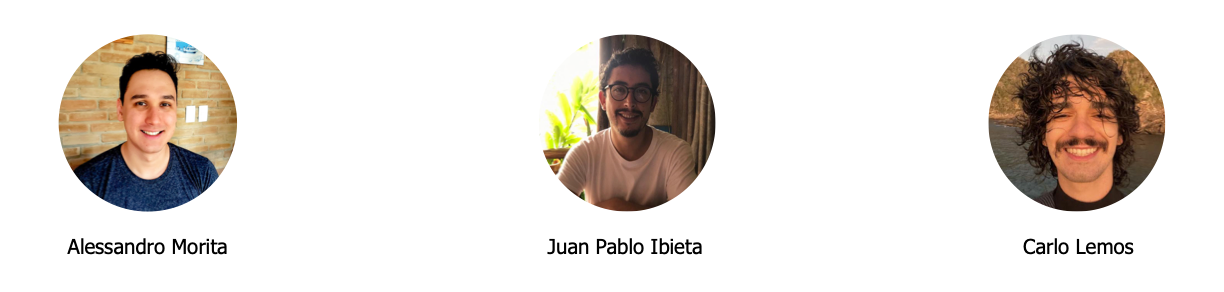

* [**Alessandro**](https://www.linkedin.com/in/atmg92/) is the Head of Data Science @DataLab, which provides him with the financial resources to do what he likes best: eating and singing at karaokes with a passion that unfortunately is not matched by his musical talents.


* [**Juan Pablo**](https://github.com/pibieta) is a Staff Data Scientist @DataLab who thinks that all work and no play makes Jack a dull boy.


* [**Carlo**](https://vitaliset.github.io/) is a Senior Data Scientist @DataLab ...

We also acknowledge Evanildo Lacerda Jr and Renato Vicente for their advice and fruitful conversations during the development of this book.

## License

The code in the notebooks is released under a [GNU GPL v3.0 license](https://www.gnu.org/licenses/gpl-3.0.en.html). The prose and pictures are released under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

## References
[1] Haibo He; Yunqian Ma, *Imbalanced Learning: Foundations, Algorithms, and Applications*. Wiley-IEEE Press (2013)

[2] Alberto Fernández, Salvador García, Mikel Galar, Ronaldo C. Prati, Bartosz Krawczyk, Francisco Herrera, *Learning from Imbalanced Data Sets*. Springer (2018)

[3] https://machinelearningmastery.com/imbalanced-classification-with-python/ 

[4] Le Borgne, Yann-Aël and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca, *Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook*. Université Libre de Bruxelles (2022). Available at https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook